**Author - Pooja Chavan**


LGMVIP - Data Science Task-1 



# **Stock Market Prediction and Forecasting using stacked LSTM**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
data = pd.read_csv(r'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
data.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [4]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date                    datetime64[ns]
Open                           float64
High                           float64
Low                            float64
Last                           float64
Close                          float64
Total Trade Quantity             int64
Turnover (Lacs)                float64
dtype: object

In [6]:
data = data.sort_values('Date')
data.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


Text(0, 0.5, 'Close')

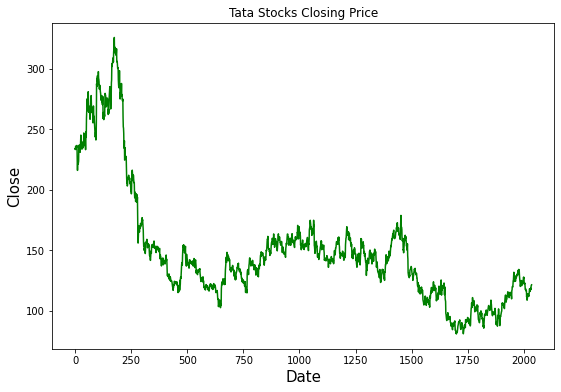

In [7]:
plt.figure(figsize = (9,6))
plt.title('Tata Stocks Closing Price')
plt.plot(data['Close'],'g')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close',fontsize=15)

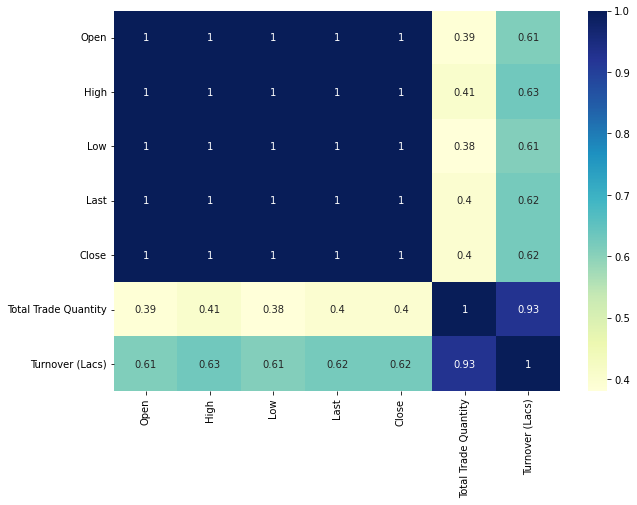

In [8]:
dcorr = data.corr()
top_corr_features = dcorr.index
plt.figure(figsize=(10,7))
#plot heatmap
sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="YlGnBu")

MinMaxScaler


From the original dataset, we can tell that each of our target value are in close proximity to one another. So, we will use MinMaxScaler to scale down all the target variables in the range of (0, 1) for the ease of computation.

In [9]:
data_close = data.reset_index()['Close']
data_close.head()
scaler = MinMaxScaler(feature_range = (0, 1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1, 1))

Splitting train, Test data

In [10]:
train_size = int(len(data_close)*0.70)
test_size = len(data_close) - train_size
train, test = data_close[0 : train_size, :], data_close[train_size : len(data_close), :1]

In [11]:
def create_matrix(ds, time_step=1):
    dataX, dataY = [], []
    for i in range(len(ds)-time_step-1):
        a = ds[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(ds[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [12]:
step=100 # time step
X_train, y_train = create_matrix(train, step)
X_test, y_test = create_matrix(test, step)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1323, 100) (1323,)
(510, 100) (510,)


In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**LSTM** **Model**

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=77, batch_size=64, verbose=1, shuffle=True).history

Epoch 1/77
19/19 [==============================] - 12s 237ms/step - loss: 0.0119 - val_loss: 0.0012
Epoch 2/77
19/19 [==============================] - 3s 165ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 3/77
19/19 [==============================] - 3s 164ms/step - loss: 9.1224e-04 - val_loss: 0.0011
Epoch 4/77
19/19 [==============================] - 3s 165ms/step - loss: 7.9236e-04 - val_loss: 9.6368e-04
Epoch 5/77
19/19 [==============================] - 3s 165ms/step - loss: 7.5618e-04 - val_loss: 9.6834e-04
Epoch 6/77
19/19 [==============================] - 3s 164ms/step - loss: 7.3682e-04 - val_loss: 9.6113e-04
Epoch 7/77
19/19 [==============================] - 3s 165ms/step - loss: 7.6126e-04 - val_loss: 9.1441e-04
Epoch 8/77
19/19 [==============================] - 3s 166ms/step - loss: 6.9879e-04 - val_loss: 8.6764e-04
Epoch 9/77
19/19 [==============================] - 6s 326ms/step - loss: 6.7513e-04 - val_loss: 8.3869e-04
Epoch 10/77
19/19 [============================

In [17]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [18]:
# Reversing the MinMax Scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


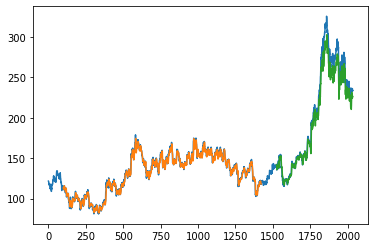

In [20]:
### Visualise the Predictions
look_back = 100
train_num_pyredict_plot = np.empty_like(data_close)
train_num_pyredict_plot[:, :] = np.nan
train_num_pyredict_plot[look_back : len(train_predict) + look_back, :] = train_predict
test_predict_plot = np.empty_like(data_close)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1 : len(data_close) - 1, :] = test_predict
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_num_pyredict_plot)
plt.plot(test_predict_plot)
plt.show()

**Future Prediction Model**


In [21]:
x_inum_pyut=test[307:].reshape(1, -1)
x_inum_pyut.shape
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()

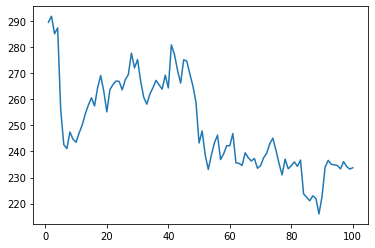

In [22]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)
plt.plot(day_new, scaler.inverse_transform(data_close[1935 : ]))

# ***Thank You !!!!***